# Naive binary classifier

In this notebook I try to detect substorm events using a very simple binary classifier. The classifier is built using a neural network trained to detect two classes :
   - 0 : not a substorm
   - 1 : is a substorm

The prediction data is the `AL index` and quantities derived from it. It was chosen because of the availability of a vast history of data, if the model we are going to define were to work we would be able to extract a big collection of substorm events. The time step is 1 minute.

Labels are given between 1992-10-13 at 06:27:26 and 1993-02-15 at 01:33:40.

### Submodules

For readability some functionalities were implemented in submodules that are imported now.

[isolated_substorms.dataset](file:///home/aschulz/isolated_substorms/isolated_substorms/dataset.py) : Load all available data.

[isolated_substorms.labels](file:///home/aschulz/isolated_substorms/isolated_substorms/labels.py) : Load all available labels.

[isolated_substorms.train_history](file:///home/aschulz/isolated_substorms/isolated_substorms/train_history.py) : Store the models training history for later analysis.

[isolated_substorms.metrics](file:///home/aschulz/isolated_substorms/isolated_substorms/metrics.py) : F1 score and other metrics.


In [1]:
import sys
sys.path.insert(0,"..")

import datetime
import os
import pickle as pkl
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
import torch.nn.functional as F
import torch.optim as optim

# kNN
import sklearn

# plotting utils
import seaborn as sn


# Data loader class
from isolated_substorms.dataset import Dataset
# Label loader class
from isolated_substorms.labels import EventLabels
# Autoencoder classes
from isolated_substorms.train_history import TrainHistory
# f1 score
from isolated_substorms.metrics import f1_score

To avoid computing the features every time the kernel is restarted we store them in a pickle file.

In [2]:
# configuration
pickle_filename="binary_classifier_feature_data.pkl"

## Training data

### Data description

First we load the original data and labels. The data is a time series with values given at 1 minute intervals. Identifying substorms has to be done by hand and only a fraction of the series has been studied. The hope is that by training the model on the available events it will be able to generate a collection of potential events, significantly decreasing the number of samples.

The *training* and *validation* sets are created from the `labeled_data` series (samples for which a label is "known"). The rest of the historical data is ignored at this stage as we have no efficient way of evaluating the models predictions.

The mean (`labeled_data_mean`) and standard deviation (`labeled_data_std`) are stored for later use.

In [3]:
# get the labels
labels=EventLabels()
print("Number of events         : {}".format(labels.size()))
print("Label timespan           : {}".format(labels.timespan()))

# get AL data
historical_data=Dataset()
# keep only data for which we have labels
labeled_data=historical_data.get_timespan(labels.timespan())
print("Labeled data shape       : {}".format(labeled_data.shape))
p=100.*float(labeled_data.shape[0])/historical_data.data.shape[0]
print("Proportion of total data : {} %".format(p))
labeled_data_mean=np.mean(labeled_data)
labeled_data_std=np.std(labeled_data)
print("Mean                     : {} nT".format(labeled_data_mean))
print("Standard deviation       : {} nT".format(labeled_data_std))
# Normalize the series
labeled_data=(labeled_data - labeled_data_mean) / labeled_data_std

Number of events         : 76
Label timespan           : 1992-10-13 06:27:26 -> 1993-02-15 01:33:40
Labeled data shape       : (179946,)
Proportion of total data : 3.416106383657303 %
Mean                     : -141.652167872584 nT
Standard deviation       : 167.2879219136791 nT




Lets take a look at the data that will be used to train the neural network. The events we are intersted in start with a `calm` phase where the value is close to zero followed by an `onset` where the index rapidly decreases. Finaly the `recovery` phase sees the index slowly return to its original value.

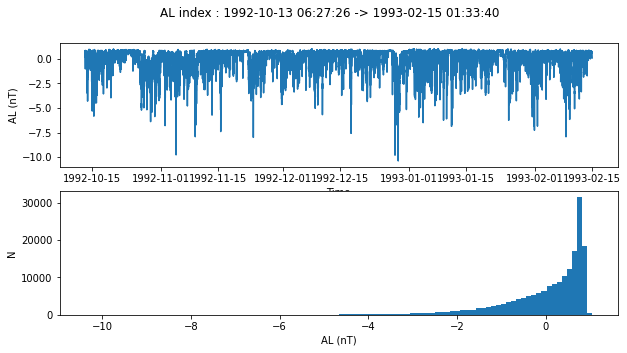

In [4]:
# plot the AL index 
from isolated_substorms.plot_utils import plot_series_and_histogram
fig=plot_series_and_histogram(labeled_data,\
         "AL index : {}".format(labels.timespan()),\
                               100,\
                               "AL (nT)",figsize=(10,5))

It is difficult to distiguish the events at this time scale. We can see that the `AL index` has mostly negative value and seems to be subject to sudden variations of great amplitude. 

The values distribution is greatly skewed towards negative values.

Neural networks generaly work better with normalized input data, we will need to perform some transformations of the input data for it to be better suited to the prediction task. 

Further more since the value of the index over a given time period may not contain sufficient information to allow accurate predictions we will add new features to the training data derived from the `AL index` values.

## Feature engineering

The presence of a substorm event at time `t` is dictated by the behaviour of the index `before` and `after` time `t`. Each sample given to our detection model will be a window of size `window_size` centered on the event onset.

We chose a `window_size` of 180 points, representing 3 hours of data.

In [5]:
# convert dataset and labels to features that we can use to train the model
def make_features(data, labels, window_size=180):
    n=data.shape[0]
    w_delta=int(window_size/2)
    # feature and label containers
    x,y=np.empty((n-window_size,window_size),dtype=float),np.empty(n-window_size,dtype=int)
    for i in range(w_delta,n-w_delta):
        x[i-w_delta]=data[i-w_delta:i+w_delta].to_numpy()
        y[i-w_delta]=labels.check_date(data.index[i])
    #for i in range(window_size,n):
    #    x[i-window_size]=data[i-window_size:i].to_numpy()
    #    y[i-window_size]=labels.check_date(data.index[i])
    return x,y

if not os.path.exists(pickle_filename):
    print("Saving features to {}".format(pickle_filename))
    x,y=make_features(labeled_data, labels)
    pkl.dump((x,y),open(pickle_filename,"wb"))
else:
    print("Loading features from {}".format(pickle_filename))
    x,y=pkl.load(open(pickle_filename,"rb"))

Loading features from binary_classifier_feature_data.pkl


There are not many events in the input data, and we will try to make additional training sets (with added uniform noise, normal noise, normalized data, synthetic samples, etc). Lets put aside the original features for futur reference (`x_original, y_original`).

We will then create a collection of *three* training sets with the following characteristics : 
   - 1. original features, imbalanced classes
   - 2. original features + synthetic sample, imbalanced class
      - a. uniform noise
      - b. normal noise

In [6]:
x_original,y_original = x,y

from isolated_substorms.data_utils import selfconcat
# synthetic samples 
x_synthetic = selfconcat(x, 10)
y_synthetic = selfconcat(y, 10)

# add uniform noise
x_unif_noise = x_synthetic + np.random.random_sample(x_synthetic.shape) - .5

# add normal noise
x_norm_noise = x_synthetic + np.random.normal(size=x_synthetic.shape)

# training set collection
training_sets= [("original",x_original, y_original),\
                ("unif_noise",x_unif_noise, y_synthetic),\
                ("norm_noise",x_norm_noise, y_synthetic)]

First we will concentrate on the original training set `x_original, y_original` to illustrate the training, predicting and evaluating procedure. Then we will pack all of the piece into a `Detector` class and compare the performances of the model with each of the training sets defined above.

## Fitting and predicting



### The classifier

Here we define a simple binary classification neural network.

The class implements a `train` function that takes the input data and performs the training procedure (with early stopping). The loss function used is `CrossEntropyLoss` and the optimizer `Stochastic gradient descent`.

The `BinaryClassifier` class is only a base class that implements the `train` method. The actual classifier must be defined by inheriting from `BinaryClassifier`.

This class can be imported from the `isolated_substorms.binary_classifier` module.


In [7]:
class BinaryClassifier(torch.nn.Module):
    def __init__(self):
        super(BinaryClassifier,self).__init__()
        self.train_history=None
    def validation_score(self, x, y):
        with torch.no_grad():
            criterion=torch.nn.CrossEntropyLoss()
            out=self.forward(x)
            loss=criterion(out,y)
            return loss.item()
    def train(self, x_train, y_train, x_validation, y_validation,\
             lr=1.e-4, momentum=.9,\
             validation_tol=1.e-6,\
             patience=10,\
             max_epochs=10000,\
             verbose=True):
        optimizer=optim.SGD(self.parameters(),lr=lr,\
                            momentum=momentum)
        criterion=torch.nn.CrossEntropyLoss(weight=torch.Tensor([.1,10.]))
        self.train_history=TrainHistory(loss_name="CrossEntropy")
        n_train=x_train.shape[0]
        for e in range(max_epochs):
            optimizer.zero_grad()
            epoch_pos=np.random.choice(range(n_train),n_train)
            out=self.forward(x_train[epoch_pos])
            loss=criterion(out,y_train[epoch_pos])
            loss.backward()
            optimizer.step()
            self.train_history.train_loss.append(loss.item())
            val_score=self.validation_score(x_validation,y_validation)
            self.train_history.validation_loss.append(val_score)
            # check stopping condition
            if self.train_history.stop_condition(validation_tol=validation_tol, patience=patience):
                if verbose:
                    print(self.train_history.stop_status)
                break
            else:
                if verbose:
                    print("epoch:{},loss:{:.5f},validation:{:.5f}".format(e,loss.item(),val_score))
        return self.train_history
    def predict(self, x):
        y_pred=np.empty(x.shape[0])
        with torch.no_grad():
            if isinstance(x, np.ndarray):
                out=self.forward(torch.from_numpy(x).float())
            else:
                out=self.forward(x)
        return np.argmax(out.numpy(),axis=1)

For a first implementation we chose an exceedingly simple model : one layer network with a sigmoid activation function. The models input is a `180` size window and its output is composed of two values between 0 and 1 representing the *confidence* of the model in both classes.

In [8]:
class MyBinClass(BinaryClassifier):
    def __init__(self, in_size=180):
        super(MyBinClass,self).__init__()
        self.l1=torch.nn.Linear(in_size,2)
    def forward(self, x):
        x=torch.sigmoid(self.l1(x))
        return x

### Training the model

Usually training a neural network is done by separating the input data into a *training* and *validation* sets. The *training* set is used for the actual parameter optimization and the validation is used for checking that the model is not overfitting.

In [9]:
# split into training and validation sets
from isolated_substorms.data_utils import split_data

x_train,y_train,x_validation,y_validation=split_data(x,y,.66)

# need them as torch Tensor objects for training
x_train=torch.from_numpy(x_train).float()
y_train=torch.from_numpy(y_train).long()
x_validation=torch.from_numpy(x_validation).float()
y_validation=torch.from_numpy(y_validation).long()

Parameters used for training. Implemented early stopping with patience value of 10.

| Parameter            | Variable name | Value |
| -------------------- |:-------------:| -----:|
| learning rate        | lr            | 1.e-2 |
| validation tolerance | validation_tol| 1.e-6 |
| training patience | patience| 10 |

CPU times: user 1min 55s, sys: 15.3 s, total: 2min 10s
Wall time: 22.5 s
End of training status : validation increased, exceeded patience


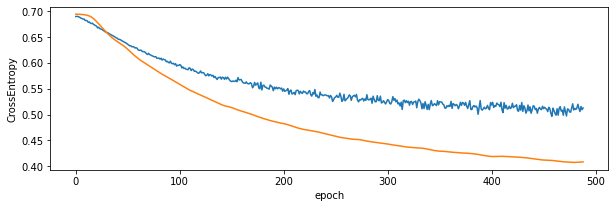

In [16]:
lr=0.01
validation_tol=1.e-6
classifier=MyBinClass()
%time train_history = classifier.train(x_train, y_train, \
                                  x_validation, y_validation, \
                                  lr=lr,\
                                  validation_tol=validation_tol,\
                                  patience=10,\
                                  verbose=False)
train_loss_fig=train_history.plot(figsize=(10,3))
print("End of training status : {}".format(train_history.stop_status))

Now that we have trained the model lets test it on the full time period.

### Prediction

Next we apply the prediction to the full time perido and view the resulting normalized confusion matrix.

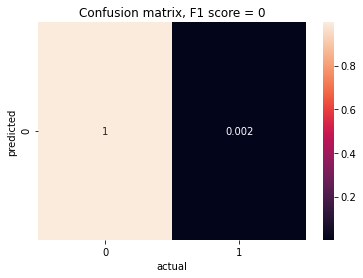

In [17]:
# plot train and validation encoded data
y_predicted=classifier.predict(x)
# confusion matrix
def confusion_matrix(predicted, actual, normalize=True):
    cm = pd.crosstab(pd.Series(name="predicted",data=predicted),\
                  pd.Series(name="actual",data=actual))
    if normalize:
        return cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    return cm

confusion=confusion_matrix(y_predicted,y)
plt.figure()
plt.title("Confusion matrix, F1 score = {}".format(f1_score(y_predicted, y)))
sn.heatmap(confusion,annot=True)
plt.show()

Sadly in this case the model only ever detects class `0`. This is probably due to the overwhelming number of `0` labeled samples in the training data.

For the sake of convenience lets define a plot function for generating a figure containing on the left the training and validation losses and on the right the confusion matrix.

The `plot_losses_and_confusion` takes a pre-fitted model, the input and label data used for predicting and computing the confusion matrix. It return a figure.

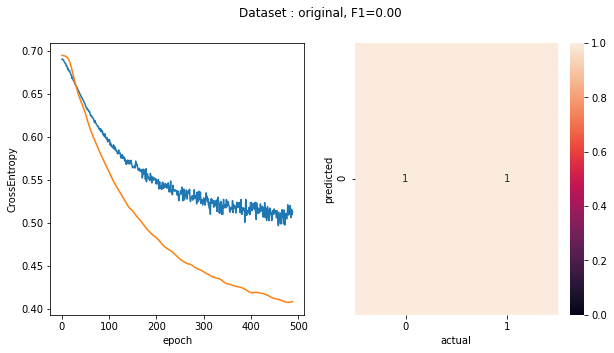

In [21]:
def plot_losses_and_confusion(fitted_model,x, y, title, **kwargs):
    # compute prediction
    nnn=fitted_model.predict(x)
    f1=f1_score(nnn, y)
    cm=confusion_matrix(nnn, y)
    # normalize the confusion matrix
    cm=cm/np.sum(cm)
    # create plot
    fig=plt.figure(**kwargs)
    plt.suptitle("{}, F1={:.2f}".format(title,f1))
    plt.subplot(1,2,1)
    fitted_model.train_history.plot(ax=plt.gca())
    plt.subplot(1,2,2)
    sn.heatmap(cm,annot=True,ax=plt.gca(),vmin=0., vmax=1.)
    return fig
fig=plot_losses_and_confusion(classifier, x, y, "Dataset : original", figsize=(10,5))

### Defining the Detector class

Pack the steps presented above into one object making comparisons easier. A detector can be initialized by `BCDetector(model_1)` where `model_1` is a callable object that returns a `torch.nn.Module` object when called. This allows the user to define their own binary classifier and create a substorm detector object out of it.

`BCDetector` is a member of the `isolated_substorms.binary_classifier` module.

In [22]:
class BCDetector:
    def __init__(self, model_constructor=None):
        if model_constructor is None:
            self.model=MyBinClass()
        else:
            self.model=model_constructor()
        self.train_history=None
    def fit(self, x, y, lr=0.0001,patience=10,validation_tol=1.e-6,\
           verbose=False):
        if verbose:
            sys.stdout.write("Fitting model...")
            sys.stdout.flush()
        # prepare the data
        x_train,y_train,x_validation,y_validation=split_data(x,y,.66)

        # need them as torch Tensor objects for training
        x_train=torch.from_numpy(x_train).float()
        y_train=torch.from_numpy(y_train).long()
        x_validation=torch.from_numpy(x_validation).float()
        y_validation=torch.from_numpy(y_validation).long()
        
        # train the model
        self.train_history = self.model.train(x_train, y_train,\
                                  x_validation, y_validation,\
                                  lr=lr,\
                                  validation_tol=validation_tol,\
                                  patience=patience,\
                                  verbose=verbose)
        if verbose:
            sys.stdout.write("done\n")
            sys.stdout.flush()
    def predict(self, x):
        # predict
        return self.model.predict(x)

Test the `BCDetector` on each of the training sets.

We use the following training parameters : 

| Parameter            | Variable name | Value |
| -------------------- |:-------------:| -----:|
| learning rate        | lr            | 1.e-2 |
| validation tolerance | validation_tol| 1.e-6 |
| training patience | patience| 10 |

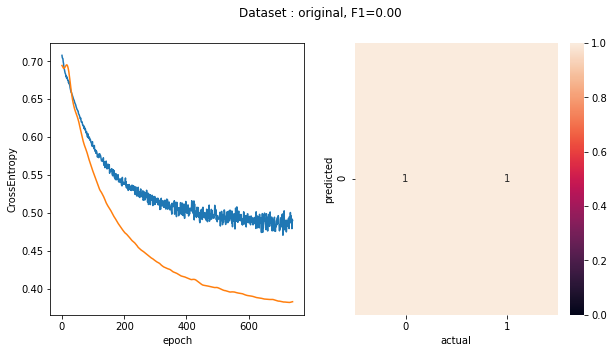

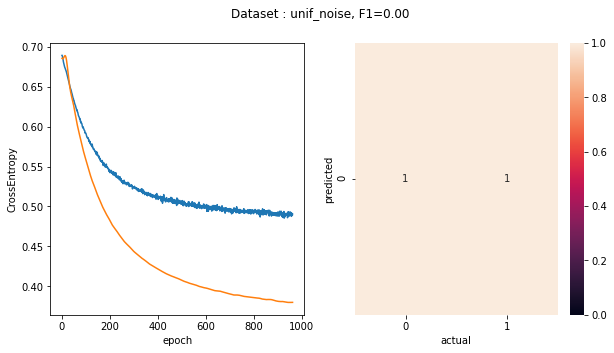

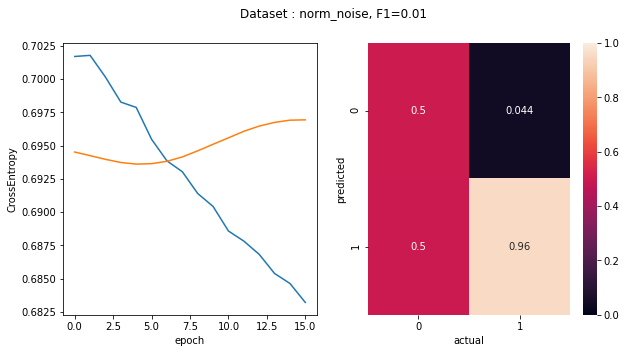

In [25]:
for name, x_t, y_t in training_sets:
    detector = BCDetector()
    detector.fit(x_t,y_t,lr=.01,patience=10,validation_tol=1.e-6,\
                 verbose=False)
    
    fig=plot_losses_and_confusion(detector.model, x, y, "Dataset : {}".format(name), figsize=(10,5))

The input data is unbalanced and that is why they are incapable of detecting `positive` samples. This is most likely due to the fact that the `negative` class far outnumbers the `positive` class.

In [26]:
for training_set_name, _, training_set_y in training_sets:
    print("{}".format(training_set_name))
    print("\tpositive samples : {}".format(np.sum(training_set_y==1)))
    print("\tnegative samples : {}".format(np.sum(training_set_y==0)))

original
	positive samples : 351
	negative samples : 179415
unif_noise
	positive samples : 3510
	negative samples : 1794150
norm_noise
	positive samples : 3510
	negative samples : 1794150


## Class balancing

One of the classes is far more represented in the training data than the other class. We want to remedy this issue.

In [27]:
# equalize classes
def balance_classes(x,y,weights):
    # positive labels
    x_positive=x[y==1]
    n_positive=x_positive.shape[0]
    # negative labels
    x_negative=x[y==0]
    # shuffle the negative labels
    x_negative=sklearn.utils.shuffle(x_negative)
    # concatenate positive and negative samples
    x_temp=np.concatenate((x_positive,x_negative[:n_positive]),axis=0)
    y_temp=np.concatenate((np.ones(n_positive),np.zeros(n_positive)),axis=0)
    return sklearn.utils.shuffle(x_temp,y_temp)
x_balanced,y_balanced=balance_classes(x,y,.5)
print("Balanced data shape :\n\tx.shape : {}\n\ty.shape : {}".format(x_balanced.shape, y_balanced.shape))

Balanced data shape :
	x.shape : (702, 180)
	y.shape : (702,)


Train the model and predict, hope to see an improvement of the F1 score.

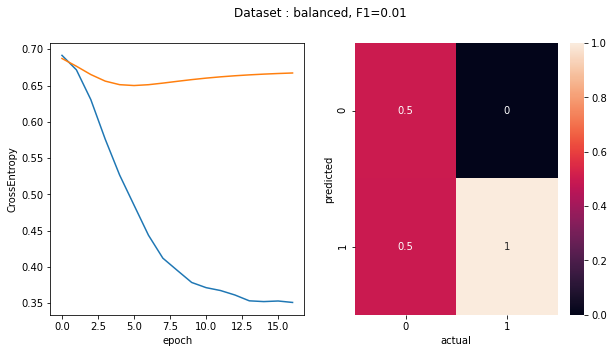

In [28]:
detector = BCDetector()
detector.fit(x_balanced,y_balanced,lr=.01,patience=10,\
             validation_tol=1.e-6)

fig=plot_losses_and_confusion(detector, x, y, "Dataset : {}".format("balanced"), figsize=(10,5))

Quite obviously the model performs much better under these conditions. Note that the `F1 score` is still very low. The training parameters had to be adapted to the new model : 

| Parameter            | Variable name | Value |
| -------------------- |:-------------:| -----:|
| learning rate        | lr            | 1.e-2  |
| validation tolerance | validation_tol| 1.e-6 |
| patience             | patience      | 10  |

As we did with the original data we are going to create a collection of training sets :
   - balanced data
   - balanced data + synthetic data (x10)
       - uniform noise
       - normal noise


In [29]:
# balanced data + synthetic samples
x_balanced_synthetic = selfconcat(x_balanced,10)
y_balanced_synthetic = selfconcat(y_balanced,10)

# add uniform noise
x_balanced_unif_noise = x_balanced_synthetic + np.random.random_sample(x_balanced_synthetic.shape)

# add normal noise
x_balanced_norm_noise = x_balanced_synthetic + np.random.normal(size=x_balanced_synthetic.shape)

# feature standardization
def standardize_features(x):
    m=np.mean(x,axis=0)
    s=np.std(x,axis=0)
    return (x-m)/s
x_bal_stan = standardize_features(x_balanced)
x_bal_synth_stan = standardize_features(x_balanced_synthetic)
x_bal_stan_unif_noise = standardize_features(x_balanced_unif_noise)
x_bal_stan_norm_noise = standardize_features(x_balanced_norm_noise)

# training set collection
balanced_training_sets=[("balanced",x_balanced,y_balanced),\
                        ("balanced + synthetic", x_balanced_synthetic, y_balanced_synthetic),\
                        ("balanced + synthetic + uniform", x_balanced_unif_noise, y_balanced_synthetic),\
                        ("balanced + synthetic + normal", x_balanced_norm_noise, y_balanced_synthetic),\
                        ("balanced  STD", x_bal_stan, y_balanced),\
                        ("balanced + synthetic STD", x_bal_synth_stan, y_balanced_synthetic),\
                        ("balanced + synthetic + uniform STD", x_bal_stan_unif_noise, y_balanced_synthetic),\
                        ("balanced + synthetic + normal STD", x_bal_stan_norm_noise, y_balanced_synthetic)]

Fit our model and predict with each of the training sets.

We use the following training parameters : 

| Parameter            | Variable name | Value |
| -------------------- |:-------------:| -----:|
| learning rate        | lr            | 1.e-2 |
| validation tolerance | validation_tol| 1.e-6 |
| training patience | patience| 10 |

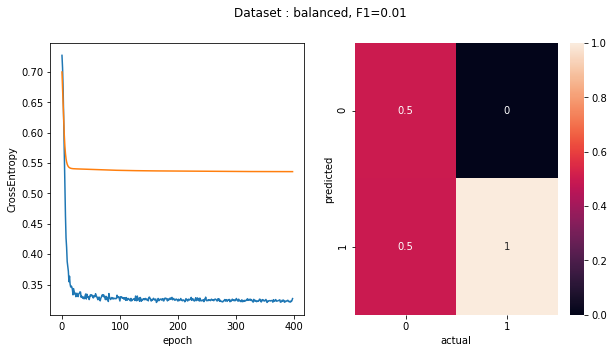

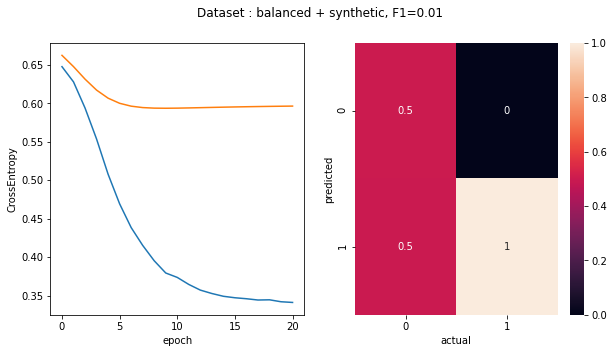

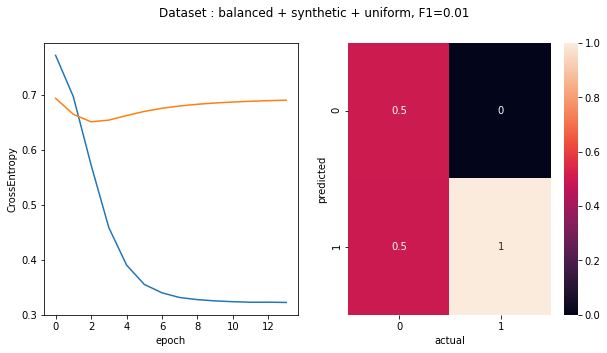

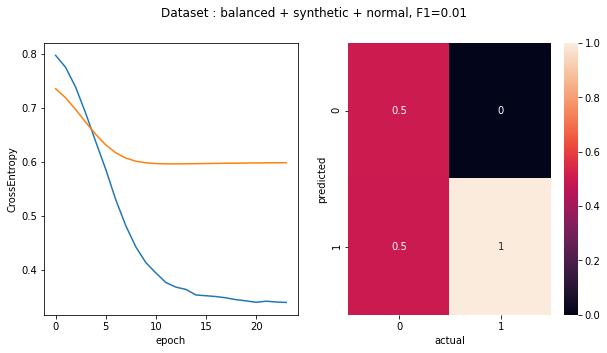

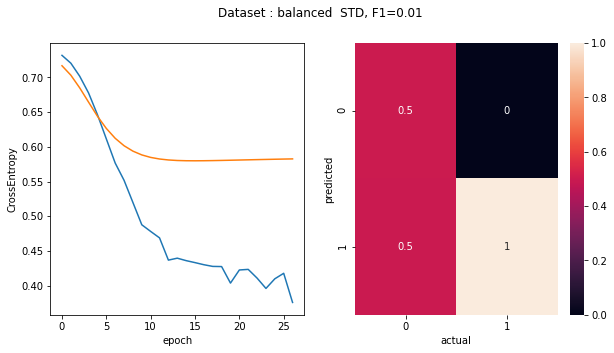

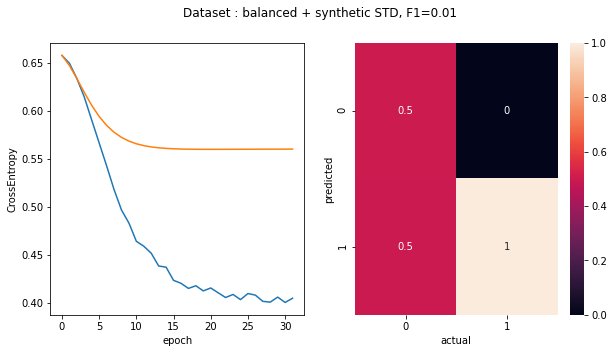

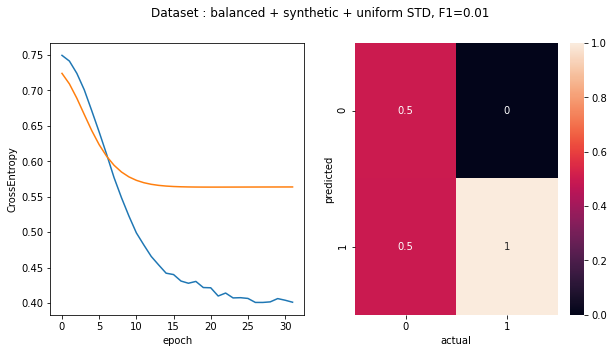

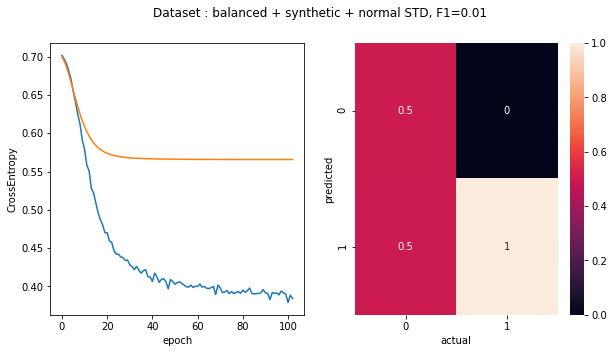

In [31]:
for name, x_t, y_t in balanced_training_sets:
    detector = BCDetector()
    detector.fit(x_t,y_t,lr=.01,patience=10,validation_tol=1.e-6)
    
    fig=plot_losses_and_confusion(detector, x, y, "Dataset : {}".format(name), figsize=(10,5))

The performance of the models are very sensitive to the initial conditions of the neural networks parameters. To evaluate the models we repeate the training/prediction procedure `n` time and plot the score distribution.

### Evaluation

The neural networks behaviours seems to be very sensitive to its parameters initial values. To get an reliable evaluation of the performance of the model we repeatedly initialize and fit the model and store its score.

For each training dataset we run 100 fittings and predictions, and we store the F1 scores in a list `simulated_f1_scores`.

In [35]:
def test_model(model_constructor, x_train, y_train, x, y, n=100):
    scores=np.empty(n)
    for i in range(n):
        model=model_constructor()
        model.fit(x_train, y_train, lr=.01, patience=10, validation_tol=1.e-6, verbose=False)
        pred=model.predict(x)
        scores[i]=f1_score(pred,y)
    return scores


simulated_f1_scores=[]
for name, x_t, y_t in balanced_training_sets:
    print("Testing on set : {}".format(name))
    simulated_f1_scores.append(test_model(BCDetector, x_t, y_t, x, y))

Testing on set : balanced
Testing on set : balanced + synthetic
Testing on set : balanced + synthetic + uniform
Testing on set : balanced + synthetic + normal
Testing on set : balanced  STD
Testing on set : balanced + synthetic STD
Testing on set : balanced + synthetic + uniform STD
Testing on set : balanced + synthetic + normal STD


We would like to view the distribution of the models scores depending on the data that was used to train it.

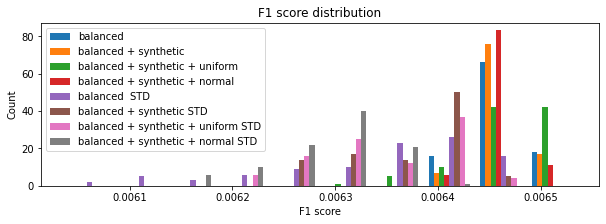

In [36]:
plt.figure(figsize=(10,3))
_,_,hist_handle=plt.hist(simulated_f1_scores,bins=10)
plt.title("F1 score distribution")
plt.xlabel("F1 score")
plt.ylabel("Count")
plt.legend([n for n,_,_ in balanced_training_sets])
# save the color patches for 
import matplotlib.patches as mpatches
bar_colors=[]
for cont in hist_handle:
    bar_colors.append([ k for k in cont[0].__dict__["_original_facecolor"]])
      
patches=[mpatches.Patch(color=k) for k in bar_colors]

Feature standardization seems to address the stability of the model and will be used throughout futur tests.

The next figure contains means and standard deviations of the scores.

<ipython-input-37-746ec2c01c08>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_xticklabels(labels=labels, rotation=70)


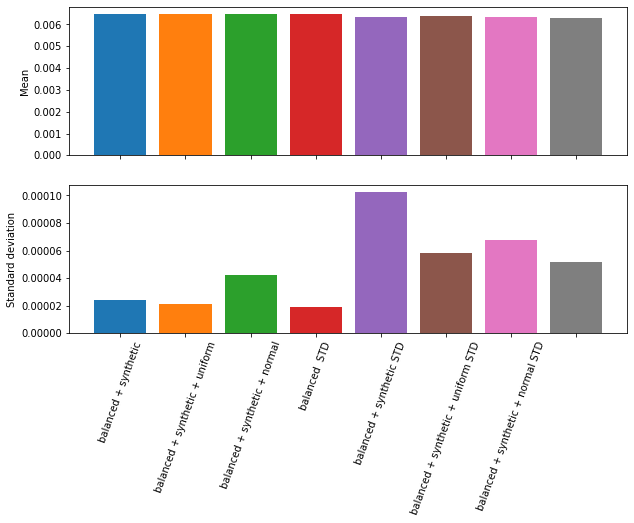

Best model : balanced + synthetic + uniform
Sorted     :
[['balanced + synthetic + normal STD' 0.006291506751147329]
 ['balanced  STD' 0.006343021252380132]
 ['balanced + synthetic + uniform STD' 0.00634550802854545]
 ['balanced + synthetic STD' 0.006367186899705628]
 ['balanced + synthetic + normal' 0.006463037980840617]
 ['balanced' 0.006465456644103855]
 ['balanced + synthetic' 0.006466496844881304]
 ['balanced + synthetic + uniform' 0.00647179792008194]]


In [37]:
# get mean and standard deviation for each set of scores in simulated_f1_scores
scores_mean=[np.mean(x) for x in simulated_f1_scores]
scores_std=[np.std(x) for x in simulated_f1_scores]
N=len(simulated_f1_scores)
# prepare plot
xticks=np.arange(len(simulated_f1_scores))
labels=np.array([name for name,_,_ in balanced_training_sets],dtype=object)
fig,axes=plt.subplots(2,1,figsize=(10,6),sharex=True)
axes[0].bar(xticks, scores_mean,color=bar_colors)
axes[0].set_ylabel("Mean")
axes[1].bar(xticks, scores_std,color=bar_colors)
axes[1].set_ylabel("Standard deviation")
axes[1].set_xticklabels(labels=labels, rotation=70)

plt.show()
print("Best model : {}".format(labels[np.argmax(scores_mean)]))


labels_and_scores=np.concatenate((labels[np.argsort(scores_mean)].reshape((N,1)),\
                  np.sort(scores_mean).reshape((N,1))),axis=1)
sorted_pos=np.argsort(labels_and_scores[:,1])

print("Sorted     :\n{}".format(labels_and_scores[sorted_pos]))

There are too many samples predicted `positive` but alot of them are consecutive frames. Lets define a function for grouping these samples together.

### False positives

Just view a couple of the false negatives we get with the best model.

In [ ]:
detector=BCDetector()
set_name,x_train,y_train=balanced_training_sets[sorted_pos[-1]]
detector.fit(x_train, y_train, lr=.00001, patience=10, validation_tol=1.e-12, verbose=False)
prediction=detector.predict(x)
# false positives
fp_mask=(prediction==1) & (y==0)
false_positives_features=x[fp_mask]
n_false_positive=false_positives_features.shape[0]
print("False positive count : {}".format(n_false_positive))
# choose N false positives and plot the corresponding sample
N=8
rpos=np.random.choice(range(n_false_positive),N)
fig,axes=plt.subplots(N,1,sharex=True,figsize=(10,7))
_=[axes[i].plot(x[rpos[i]]) for i in range(N)]
plt.suptitle("{}\nfalse positive samples".format(set_name))
plt.show()

### 1D CNN

Lets try adding a 1D convolution layer to the detection model and see its performances. 

Firstly we define a new classification model that takes as input batches of 2 dimensional data (1 channel, `window_size` data points. Notice that the input size is not the same then it was for the previously studied models. The training and testing datasets are reshaped by calling the `MyCNNBinClass.reshape_input` method, this method is executed each time the `forward` method is called.
 

In [ ]:
### 1D CNN binary classificator
class MyCNNBinClass(BinaryClassifier):
    def __init__(self, out_channels=5, kernel_dim=5):
        super(MyCNNBinClass,self).__init__()
        self.out_channels=out_channels
        self.kernel_dim=kernel_dim
        self.conv1 = torch.nn.Conv1d(1, out_channels, kernel_dim)
        self.fc1 = torch.nn.Linear(880, 128)
        self.fc2 = torch.nn.Linear(128, 2)
    def forward(self, x):
        x = self.reshape_input(x)
        x = self.conv1(x)
        x = x.view(-1, self.kernel_dim*x.shape[-1])
        x = F.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x
    def reshape_input(self,x):
        return torch.from_numpy(np.expand_dims(x,1)).float()
        


Now we test the new detector on the best dataset identified in the previous steps. The training parameters :


| Parameter            | Variable name | Value |
| -------------------- |:-------------:| -----:|
| learning rate        | lr            | 1.e-6  |
| validation tolerance | validation_tol| 1.e-12 |
| patience             | patience      | 100  |

In [ ]:
# get best performing dataset
set_name,x_train,y_train=balanced_training_sets[sorted_pos[-1]]
# initialize the detector
cnn_detector = BCDetector(model_constructor=MyCNNBinClass)
# fit the detector to the data
cnn_detector.fit(x_train, y_train, lr=.00001, patience=100, validation_tol=1.e-12, verbose=False)
print("Training stop status : {}".format(cnn_detector.model.train_history.stop_status))
# plot loss
fig=plot_losses_and_confusion(cnn_detector, x, y, "Dataset : {}".format(set_name), figsize=(10,5))


Notice that the F1 score for this model is higher than the score obtained with all previous models, but the increase is still too small.

In [ ]:
prediction=cnn_detector.predict(x)
# false positives
fp_mask=(prediction==1) & (y==0)
false_positives_features=x[fp_mask]
n_false_positive=false_positives_features.shape[0]
print("False positive count : {}".format(n_false_positive))
# choose N false positives and plot the corresponding sample
N=8
rpos=np.random.choice(range(n_false_positive),N)
fig,axes=plt.subplots(N,1,sharex=True,figsize=(10,10))
_=[axes[i].plot(x[rpos[i]]) for i in range(N)]
plt.suptitle("{}\nfalse positive samples".format(set_name))
plt.show()

In [ ]:
## Training on the log index
temp_data=labeled_data*labeled_data_std + labeled_data_mean
temp_data=temp_data * (-1.)
temp_data=temp_data - np.min(temp_data)
log_data=np.log(1.+temp_data)
labels=EventLabels()

x_log,y_log=make_features(log_data, labels)
x_log_unbalanced, y_log_unbalanced=x_log,y_log
x_log,y_log=balance_classes(x_log,y_log,.5)


x_log_mean=np.mean(x_log,axis=0)
x_log_std =np.std(x_log,axis=0)
#print("Log data mean : {}".format(x_log_mean))
#print("Log data std  : {}".format(x_log_std))

x_log_unbalanced=(x_log_unbalanced-x_log_mean)/x_log_std
x_log=(x_log-x_log_mean)/x_log_std

# train the model
detector=BCDetector(model_constructor=MyCNNBinClass)
detector.fit(x_log, y_log, patience=10,lr=.0001)
# transform the test data to fit the model
fig=plot_losses_and_confusion(detector,x_log_unbalanced, y_log_unbalanced, "Dataset : Log data")

# train the model
detectorbase=BCDetector(model_constructor=MyCNNBinClass)
detectorbase.fit( x_bal_stan, y_balanced,patience=10,lr=.0001)
# transform the test data to fit the model
fig=plot_losses_and_confusion(detectorbase, x, y, "Dataset : balanced STD")



In [ ]:
prediction=detector.predict(x_log_unbalanced)
# false positives
fp_mask=(prediction==1) & (y==0)
false_positives_features=x[fp_mask]
n_false_positive=false_positives_features.shape[0]
print("False positive count : {}".format(n_false_positive))
# choose N false positives and plot the corresponding sample
N=10
rpos=np.random.choice(range(n_false_positive),N)
fig,axes=plt.subplots(N,1,sharex=True,figsize=(10,7))
_=[axes[i].plot(x[rpos[i]]) for i in range(N)]
plt.suptitle("{}\nfalse positive samples".format("Log data"))
plt.show()

In [ ]:
### FFT
import scipy.fftpack
# transform data
def get_fft_transform(x):
    x_fft=[]
    N=x.shape[1]
    for i in range(x.shape[0]):
        fft_t=np.fft.rfft(x[i,:],norm="ortho")
        fft_t=2.0/N  * np.abs(fft_t[:N//2])
        x_fft.append(fft_t)
    return np.array(x_fft)

sys.stdout.write("Computing FFTs...")
sys.stdout.flush()
x_fft_balanced=get_fft_transform(x_log)
x_fft_unbalanced=get_fft_transform(x_log_unbalanced)
x_fft_original=get_fft_transform(x)
sys.stdout.write("done\n")
sys.stdout.flush()

# feature standardization
mean_t, std_t=np.mean(x_fft_balanced,axis=0), np.std(x_fft_balanced, axis=0)
x_fft_balanced=standardize_features(x_fft_balanced)
x_fft_original=(x_fft_original - mean_t)/std_t

# create the classification model
prediction=np.array([1,1])
print(prediction, prediction==1)
print(np.all(prediction==1))
while np.all(prediction==1) or np.all(prediction==0):
    print("Training, testing, predicting")
    detector=BCDetector(model_constructor=lambda : MyBinClass(90))
    detector.fit(x_fft_balanced, y_log, lr=0.000001, verbose=True, validation_tol=1.e-12,\
             patience=10)   
    # false positives in the training data
    prediction=detector.predict(x_fft_unbalanced)
    print(np.sum(prediction==1), np.sum(prediction==0))
fig=plot_losses_and_confusion(detector,x_fft_unbalanced, y_log_unbalanced, "Dataset : fft")

# false positives
fp_mask=(prediction==1) & (y_log_unbalanced==0)
false_positives_features=x[fp_mask]
n_false_positive=false_positives_features.shape[0]
print("False positive count : {}".format(n_false_positive))
# choose N false positives and plot the corresponding sample
N=6
rpos=np.random.choice(range(n_false_positive),N)
fig,axes=plt.subplots(N,1,sharex=True,figsize=(10,10))
_=[axes[i].plot(false_positives_features[rpos[i]]) for i in range(N)]
plt.suptitle("{}\nfalse positive samples".format("FFT"))
plt.show()

In [ ]:
detectorbase=BCDetector(model_constructor=MyCNNBinClass)
detectorbase.fit( x_bal_stan, y_balanced,patience=1000,lr=.0001)
prediction=detectorbase.predict(x)
print(np.sum(prediction==1), np.sum(prediction==0))
class Event:
    def __init__(self, state, beg, end=None):
        self.state=state
        self.begin=beg
        self.end=end
    def __len__(self):
        return self.end-self.begin
    def __str__(self):
        return "Event(begin:{},end:{},state:{},len:{})".format(self.begin, self.end, self.state,self.__len__())
def prediction_to_catalogue(pred):
    events=[]
    curr_event=Event(pred[0],0)
    for i in range(1,pred.shape[0]):
        #print(i, pred[i],curr_event)
        if pred[i]==curr_event.state:
            curr_event.end=i
        else:
            if not curr_event.end is None:
                events.append(curr_event)
            curr_event=Event(pred[i],i)
    if not curr_event.end is None:
        events.append(curr_event)
    return events
events=prediction_to_catalogue(prediction)
print("Prediction shape : {}".format(prediction.shape))
print("Number of events : {}".format(len(events)))

for event in events:
    event_len=len(event)
    print(event)
    if event_len>120 and event.state:
        plt.figure()
        plt.title(event.__str__())
        plt.plot(labeled_data[event.begin:event.end+90])
        print(labeled_data[event.begin:event.end+90].shape)
        plt.savefig("false_pos_fft/{}.png".format(event.begin))


In [ ]:
class MyCNNBinClassFFT(BinaryClassifier):
    def __init__(self, out_channels=5, kernel_dim=5):
        super(MyCNNBinClassFFT,self).__init__()
        self.out_channels=out_channels
        self.kernel_dim=kernel_dim
        self.conv1 = torch.nn.Conv1d(1, out_channels, kernel_dim)
        self.fc1 = torch.nn.Linear(430, 128)
        self.fc2 = torch.nn.Linear(128, 2)
    def forward(self, x):
        x = self.reshape_input(x)
        x = self.conv1(x)
        x = x.view(-1, self.kernel_dim*x.shape[-1])
        x = F.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x
    def reshape_input(self,x):
        return torch.from_numpy(np.expand_dims(x,1)).float()

# create the classification model
detector=BCDetector(model_constructor=MyCNNBinClassFFT)
detector.fit(x_fft_balanced, y_balanced, lr=0.00001, verbose=True, validation_tol=1.e-12,patience=10)
fig=plot_losses_and_confusion(detector,x_fft_original, y, "Dataset : fft")

# false positives in the training data
prediction=detector.predict(x_fft_original)
# false positives
fp_mask=(prediction==1) & (y==0)
false_positives_features=x[fp_mask]
n_false_positive=false_positives_features.shape[0]
print("False positive count : {}".format(n_false_positive))
# choose N false positives and plot the corresponding sample
N=12
rpos=np.random.choice(range(n_false_positive),N)
fig,axes=plt.subplots(N,1,sharex=True,figsize=(10,10))
_=[axes[i].plot(false_positives_features[rpos[i]]) for i in range(N)]
plt.suptitle("{}\nfalse positive samples".format("FFT"))
plt.show()

### BROUILLON

In [ ]:
def check_false_positive(i,y_pred,y):
    if i>y.shape[0]-1:
        return False
    return y_pred[i]==1 and y[i]==0
def get_prediction_state(i,y_pred,y):
    if i>y.shape[0]-1:
        return None
    return int(y_pred[i]),int(y[i])
def get_following_same_state(i,y_pred,y,curr_state,tol=1):
    pos_range=[k for k in range(1,tol+1)]
    a=[]
    latest_pos=i
    for p in pos_range:
        state=get_prediction_state(i+p,y_pred,y)
        if state is None:
            return None
        if np.all(state==curr_state):
            a.append(i+p)
            if latest_pos<i+p:
                latest_pos=i+p
    if len(a)==0:
        return None
    return latest_pos,a
def group_consecutive_false_positives(y_pred,y,tol=1):
    n=y_pred.shape[0]
    i=0
    groups={(0,0):[],(0,1):[],(1,0):[],(1,1):[]}
    while i<n:
        prediction_state=get_prediction_state(i,y_pred,y)
        indices=[i]
        # check all following samples with the same state
        nextg=get_following_same_state(i,y_pred,y,prediction_state,tol=tol)
        while not nextg is None:
            indices=indices+nextg[1]
            i=nextg[0]+1
            nextg=get_following_same_state(i,y_pred,y,prediction_state,tol=tol)
        groups[prediction_state].append(indices)
        i=i+1

    return groups
            
prediction_groups=group_consecutive_false_positives(y_predicted, y_org, tol=30)
print("Groups : {}".format(len(prediction_groups[1,0])))
for k in prediction_groups:
    print("{}:{}".format(k,len(prediction_groups[k])))


In [ ]:
for fp in prediction_groups[1,0]:
    # get begining and end dates
    beg_dt=labeled_data.index[fp[0]]
    end_dt=labeled_data.index[fp[-1]+180]
    if end_dt-beg_dt<datetime.timedelta(hours=3):
        continue
    fig=plt.figure(figsize=(10,5))
    plt.plot(labeled_data[beg_dt:end_dt])
    plt.xlabel("time")
    plt.ylabel("AL index")
    plt.suptitle("index {} to {} ({} samples, {})".format(fp[0],fp[-1],len(fp),end_dt-beg_dt))
    plt.show()
    plt.close(fig)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
a=np.linspace(0,1,100)
y=np.sin(a)
%matplotlib
fig=plt.figure(figsize=(10,5))
plt.plot(labeled_data[beg_dt:end_dt])
plt.xlabel("time")
plt.ylabel("AL index")
plt.suptitle("index {} to {} ({} samples, {})".format(fp[0],fp[-1],len(fp),end_dt-beg_dt))
plt.show()
